In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# K-Means Clustering

The first clustering algorithm we will discuss is k-means clustering. The goal of k-means clustering is to partition a dataset into K distinct, non-overlapping clusters. 

The user must specify the number of clusters, K, they believe the data should be partitioned into. The k-means algorithm assigns observations to these clusters such that each observation belongs to exactly one of the K clusters. We can refer to these clusters using sets of indices $C_1,...C_k$. If observation i is in cluster k, then its index $i$ would be in the set $C_k$. After clustering the data, the user uses knowledge from the dataset combined with domain knowledge to interpret the clusters.

## Within-Cluster Variation

In k-means clustering, a good clustering is one where the variation within clusters is small (that is, observations within a cluster are similar to each other). We refer to this concept as within-cluster variation and choose the clusters that minimize the total within-cluster variation across all k clusters. This ideas is depicted in the image below.

![](withinclustervariation.png)

There are different ways to define within-cluster variation, but the most common choice is to use squared Euclidean distance. Recall, we talked about Euclidean distance and other distance metrics in [Chapter 21](../../21/classification_intro.ipynb). Euclidean distance is the shortest, straight-line distance between two points. We can use this to calculate the squared distance between each pair of points in a cluster using the following equation:

```{math}
:label: wcv
WCV = \frac{1}{|C_q|} \sum_{i,i' \in C_q} \sum_{j=1}^p (x_{ij} - x_{i'j'})^2,
```
where $i$ and $i'$ are two observations in cluster $q$, $j$ and $j'$ are the observed value of feature $j$ for each of the observations respectively, and $|C_q|$ is the size (number of observations) of cluster $q$ used to ensure the size of the cluster does not affect the within-cluster variation. 

There are other equations that can be used to calculate within-cluster variation, just as there were multiple distance metrics that can be used in the K-Nearest-Neighbors algorithm, but this is the one we will focus on in this chapter.

Therefore, we attempt to minimize $\sum_{q=1}^k WCV$, the total within-cluster variation across all k clusters.

However, the exact solution to this minimization is difficult to find. The K-means algorithm attempts to approximate the solution by finding a local minimum (approximation) that may or may not be the global minimum (exact solution).

## The Algorithm

Now that we understand what we are trying to minimize, let's walk through the algorithm depicted in {prf:ref}`k-means`.

```{prf:algorithm} K-Means Clustering
:label: k-means

**Inputs** Given a number of clusters $K$

**Output** A partitioning of the dataset into $K$ distinct clusters.

1. Initialize $K$ random centroids by randomly selecting $K$ points from the dataset.
2. While the clusters continue to change (the algorithm hasn't converged):
	1. Construct clusters by associating each point with closest centroid
	2. Calculate new centroids for each cluster by averaging the observations for each feature.

**Note:** The final clustering could depend on where the centroids are initialized.
```


First, we specify the number of clusters, k, that we want to partition the dataset into. Then, we randomly select k datapoints to be our initial cluster **centroids**. A centroid is the center of a cluster of points. It can be calculated by calculating the average value of each feature across points. Once we have our initial centroids, we repeat a series of steps. 1. We create clusters by associating each datapoint with its closest centroid. 2. We update the value of our centroids by averaging the value of each feature across the datapoints we clustered together in 1. We continue repeating 1 and 2 until our algorithm has **converged**. Convergence refers to the algorithm approaching a steady state or a single value. Here, our algorithm has converged when our centroids and clusters stop changing. Once the algorithm converges, the resulting clusters are the final clusters returned to the user.

Because this algorithm does not find the exact solution to our minimization, if we run the algorithm multiple times on the same data, we may not always get the same clusters. 

The animation below shows how the algorithm initializes and updates until convergence.

![](kmeans_animation.gif)

Notice, that if we change the initial centroids, it can result in different clusters.

![](kmeans_animation_2.gif)

The final clusters are dependent on the randomly initialized centroids. Because of this, it is important that we run the algorithm multiple times and calculate the within-cluster variation the resulting clusters. Then, we should pick the clustering that provided the smallest within-cluster variation.

## How to Choose k

Sometimes, we have an idea, based on domain knowledge, of how many clusters are in our dataset. But, other times, we may need to try various numbers of clusters until we find a good clustering. As we increase k, our total within-cluster variance will naturally decrease. (Consider the difference between within-cluster variation when k=1 and when k=n.) The 'best' value for k is the point at which adding more clusters no longer produces large decreases in within-cluster variation. In other words, we want to choose a k where diminishing returns for increasing k are no longer worth the additional cost of adding more clusters. We can see this visually using an **elbow plot**. An elbow plot is a line graph of the within-cluster variation for different values of k. An example is shown below.


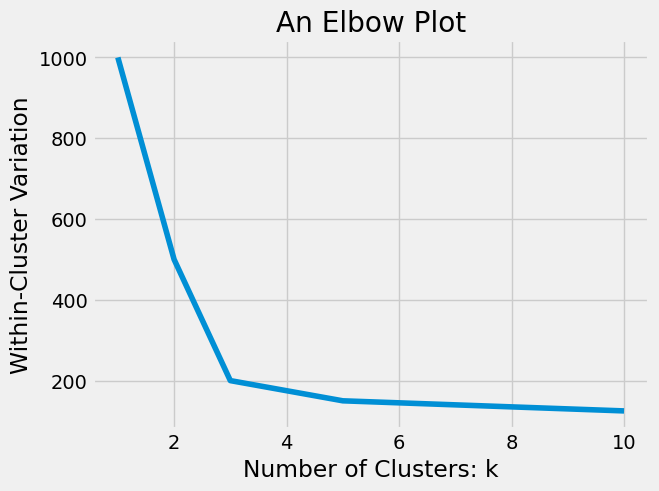

In [3]:
x = np.array([1,2,3,5,10])
y = np.array([1000,500,200,150,125])
plt.plot(x,y)
plt.xlabel("Number of Clusters: k")
plt.ylabel("Within-Cluster Variation")
plt.title('An Elbow Plot');

We call this an elbow plot because it looks similar to the bend in your arm. The optimal value of k is the value at the 'elbow' bend of the plot, where we no longer see large decreases in within-cluster variation as k gets larger. In the plot above, the optimal choice would be k=3. 

You may notice that this sounds similar to the discussion we had in [Section 21.3](../../21/3/Features_to_Consider.ipynb) about choices of parameters for K-Nearest-Neighbors. The value of k is a tuning parameter for the k-means algorithm and so we can get the values of within-cluster variation to make our elbow plot in the same way as in Chapter 21, using cross validation. We will illustrate this further with an example [later in this section](../../25/1/kmeans.ipynb#a-larger-example). But first, let's implement the k-means algorithm in Python.

## The Algorithm in Code

Imagine we have data on coins from an unfamiliar currency. The only information we have is measurements of coin weight and diameter for 100 coins. We can use clustering to get an idea of which coins are probably the same denomination, what the average weight and diameter of each denomination is, and even how many denominations are likely. I've created some data and plotted it below:

In [4]:
coins = pd.read_csv("../../data/coins.csv")
coins.head()

,weight,diameter
0,2.28,0.703386
1,2.24,0.697075
2,2.30,0.702715
3,2.05,0.706927
4,2.27,0.701173


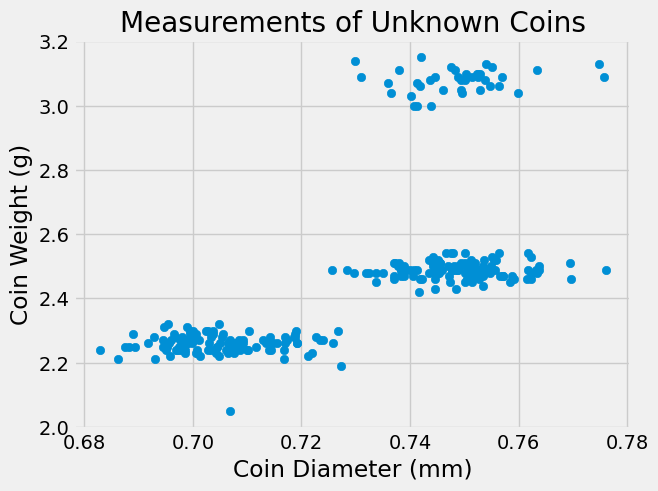

In [5]:
plt.scatter(coins['diameter'],coins['weight'])
plt.xlabel('Coin Diameter (mm)')
plt.ylabel('Coin Weight (g)')
plt.title('Measurements of Unknown Coins');

Since our dataset only has two variables, it is easy to visualize using a scatterplot. Based on the plot above, it looks like there are 3 clusters of points that could correspond to 3 different coin denominations. Let's perform k-means clustering on the coin data.

First, just as we did in Chapters 17 and 21, we need to standardize our data. This ensures that coin weight doesn't have more affect on the distance measurement than the diameter just due to its relative size. Recall the `standard_units` function we wrote in [Chapter 17](../../17/2/correlation.ipynb):

In [6]:
# From Chapter 17
def standard_units(my_data):
    '''Takes in an array of data and returns that data standardized by subtracting the mean 
    and dividing by the standard deviation'''

    my_mean = np.mean(my_data)
    my_stddev = np.std(my_data, ddof = 1)
    standardized_data = (my_data - my_mean) / my_stddev
    
    return standardized_data

coins_su = coins.copy()
coins_su['diameter'] = standard_units(coins['diameter'])
coins_su['weight'] = standard_units(coins['weight'])
coins_su.sample(5)

,weight,diameter
271,-0.038455,0.274847
116,0.218450,1.318529
193,-0.038455,1.122266
192,-0.075156,0.474736
77,-0.809170,-0.730083


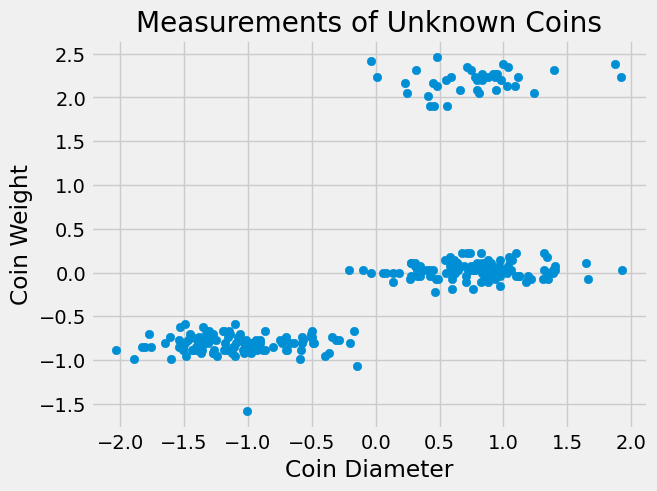

In [7]:
plt.scatter(coins_su['diameter'],coins_su['weight'])
plt.xlabel('Coin Diameter')
plt.ylabel('Coin Weight')
plt.title('Measurements of Unknown Coins');

Notice, standardizing the data does not change the clusters! Our graph looks the same, we have just changed the units of measurement.

Now, let's work through the k-means algorithm. First we need to decide on a number of clusters. Since our data is two dimensional and we can easily visualize it, we can tell from the graph that there seem to be 3 clusters. Now that we have chosen k, the function below accomplishes Step 1 of {prf:ref}`k-means` by using `.sample()` from `pandas` to randomly select k = 3 points to be the starting centroids for the 3 clusters. 

In [8]:
def initialize_centroids(df,k):
    '''Takes in a dataframe and the number of clusters and returns k random observations
    from the dataframe to serve as initialized centroids'''
    centroids = df.sample(k)
    return centroids

np.random.seed(312) # Set a random seed so our results are replicable
centr = initialize_centroids(coins_su, 3)
centr

,weight,diameter
210,2.016785,0.406022
161,0.108348,0.828466
199,-0.038455,1.124935


We can depict these centroids on our scatterplot using red stars.

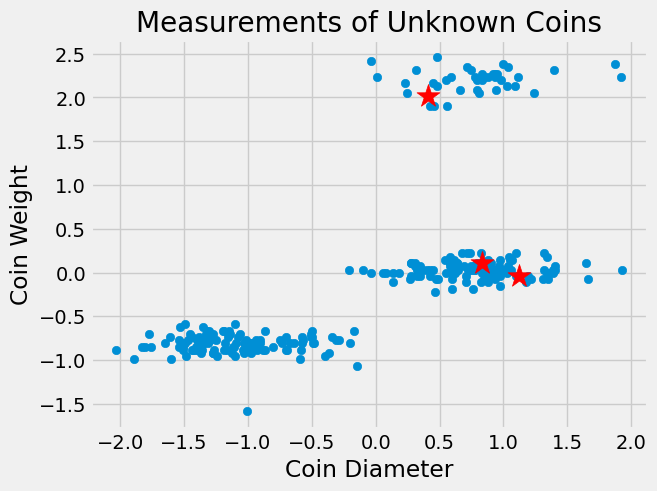

In [9]:
plt.scatter(coins_su['diameter'],coins_su['weight'])
plt.scatter(centr['diameter'], centr['weight'], marker='*', s=300,color="red", label='centroid')
plt.xlabel('Coin Diameter')
plt.ylabel('Coin Weight')
plt.title('Measurements of Unknown Coins');

Notice, there is not one centroid in each cluster. This is because initial centroids are chosen completely at random so there is no guarantee there will be an initialized centroid in each cluster. But, the centroids will move as the algorithm continues into Step 2.

Step 2 of {prf:ref}`k-means` has two parts and continues until our centroids stop moving at which point the algorithm converges. Part 1, assign all points to the cluster corresponding to the closest centroid. Part 2, recalculate centroids.

To do this, we need a way of finding the closest centroid. As in [Chapter 21](../../21/classification_intro.ipynb), we could choose between many different distance metrics, but we will focus on the most commonly used metric: Euclidean distance. Below, we've rewritten the `distance` function from Chapter 21 which computes the Euclidean distance between two points.

In [10]:
# From Chapter 21
def distance(pt1, pt2):   
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

We need to use `distance` to calculate the distance between every point and every centroid. Since we will be doing this multiple times (until convergence), we can write a function to make this easier. The function below iterates through each centroid and uses `.apply()` to apply the function `distance_from_point` to each point (aka row) in the dataframe resulting in a two-dimensional array of distances between each point and each centroid. The function `distance_from_point` is a rewritten version of `distance` that takes in a single argument to make it easier to apply to a dataframe.

In [11]:
def compute_distance(df, centroids):
    '''Takes in a dataframe and a smaller dataframe of centroids and returns a 2D array containing
    the distance between each observation in the dataframe and each centroid'''
    K=centroids.shape[0]
    distances_ar = np.zeros((df.shape[0], K))
    
    for k in np.arange(K):
        point=centroids.iloc[k]        
        def distance_from_point(row):
            '''A helper function allowing the distance function to be applied to each row of the dataframe'''
            return distance(point, np.array(row))
        distances_ar[:,k] = df.apply(distance_from_point,axis=1).values
    return distances_ar

dist = compute_distance(coins_su,centr)
dist[:10]

array([[3.16596349, 2.15855311, 2.38724186],
       [3.42982491, 2.46290942, 2.68726012],
       [3.11684329, 2.15754752, 2.39437962],
       [3.86457696, 2.4944009 , 2.63146375],
       [3.24494848, 2.25944071, 2.48789417],
       [3.22209924, 2.30245789, 2.5401207 ],
       [3.17273802, 2.29882981, 2.54367125],
       [3.14267035, 2.0179915 , 2.23115643],
       [3.15383202, 2.04057977, 2.25493927],
       [3.12933998, 2.04103004, 2.26016437]])

The resulting 2D array has 3 columns corresponding to the three centroids and one row for each point in the dataset. We want to find the closest centroid to each point and assign the point to that cluster. We can do this using `np.argmin()` which takes in an array and returns the index of the smallest value along an axis. Here, we want to know which column has smallest value in each row (aka the closest centroid to each point) so we use `axis = 1`.

In [12]:
clust = np.argmin(dist, axis=1)
clust

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 2, 2, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 2, 1, 0, 1, 1, 2, 0, 2, 0, 0, 2, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 0, 1, 2, 0, 0, 1, 0,
       1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 0,
       0, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 2, 2, 2, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       2, 1, 2, 0, 0, 0, 1, 1])

This results in an array of cluster memberships for each point in the dataset. Let's visualize these initial clusters.

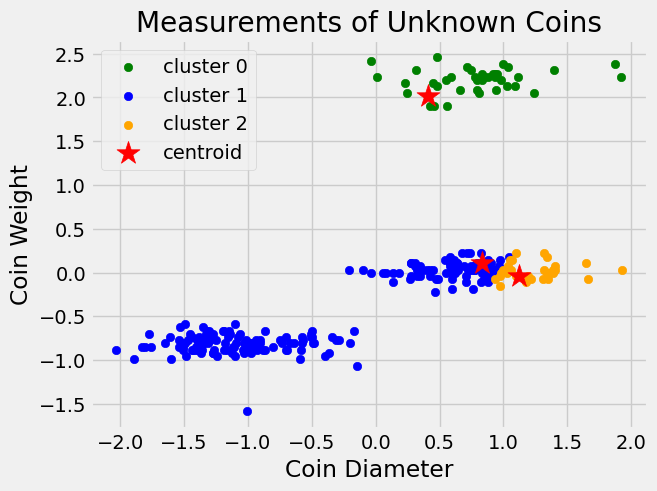

In [13]:
plt.scatter(coins_su[clust == 0].diameter, coins_su[clust == 0].weight,
            color='green', label='cluster 0')
plt.scatter(coins_su[clust == 1].diameter, coins_su[clust == 1].weight,
            color='blue', label='cluster 1')
plt.scatter(coins_su[clust == 2].diameter, coins_su[clust == 2].weight,
            color='orange', label='cluster 2')
plt.scatter(centr['diameter'], centr['weight'], marker='*', s=300,color="red", label='centroid')
plt.legend()
plt.xlabel('Coin Diameter')
plt.ylabel('Coin Weight')
plt.title('Measurements of Unknown Coins');


Now, we need to update our centroids for the three clusters by finding the cluster average diameters and cluster average weights.

In [14]:
def compute_centroids(df, labels, K):
        centroids = np.zeros((K, df.shape[1]))
        for k in range(K):
            centroids[k, :] = df[labels == k].mean()
        return centroids

centr = pd.DataFrame(compute_centroids(coins_su, clust, 3), columns=coins_su.columns)
centr

,weight,diameter
0,2.198454,0.779702
1,-0.442530,-0.352587
2,0.017743,1.229040


And we can visualize how our centroids have moved.

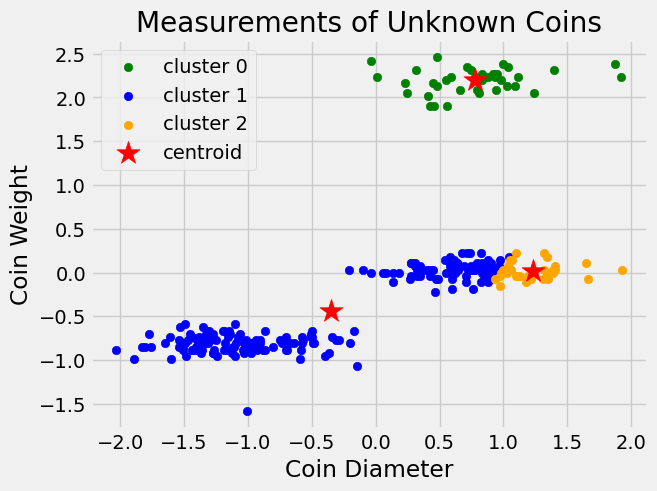

In [15]:
plt.scatter(coins_su[clust == 0].diameter, coins_su[clust == 0].weight,
            color='green', label='cluster 0')
plt.scatter(coins_su[clust == 1].diameter, coins_su[clust == 1].weight,
            color='blue', label='cluster 1')
plt.scatter(coins_su[clust == 2].diameter, coins_su[clust == 2].weight,
            color='orange', label='cluster 2')
plt.scatter(centr['diameter'], centr['weight'], marker='*', s=300, color="red", label='centroid')
plt.legend()
plt.xlabel('Coin Diameter')
plt.ylabel('Coin Weight')
plt.title('Measurements of Unknown Coins');


We continue the process of calculating distances, reassigning clusters, and updating centroids until our centroids stop moving (or stop moving significantly). We can do this in code using a `while loop` which continually runs the code inside the loop until its termination criterion is met. 

Below, we combine these individual steps into one function to perform k-means clustering. We start by initializing the centroids, then move to a while loop that repeats the process of assigning clusters and updating centroids. The while loop should terminate when our algorithm has converged. Not every dataset will have clear and distinct clusters like the ones above. This can make it difficult for the algorithm to converge if we simply look for equality between old and updated centroids, as the centroids will keep moving slightly. Because of this, it can be useful to add either a **tolerance** where the while loop terminates when the centroids are similar enough (within some threshold) to the old centroids, or a maximum number of iterations where the while loop terminates after some number of iterations regardless of whether it has reached convergence.

The while loop below terminates when the centroids calculated at the end of the iteration are within 0.001 unit in each direction of the centroids the iteration started with. We test this using `.allclose()` from the `numpy` library which tests whether two arrays contain values within a given tolerance, `atol`, (in this case 0.001) of each other. 

In [19]:
def k_means(df, K):
    '''Carries out the k-means algorithm on df with K clusters and returns the centroids and cluster membership'''
    centr = initialize_centroids(df, K)
    old_centr = np.zeros(centr.shape)
    
    while not np.allclose(centr, old_centr, atol=0.001):
            old_centr = centr.copy()
            dist = compute_distance(df, old_centr)
            clust = np.argmin(dist, axis=1)
            centr = pd.DataFrame(compute_centroids(df, clust, K), columns = df.columns)
    
    return (centr, clust)
centr, clust = k_means(coins_su, 3)

The following graph shows the final clustering returned by our function.

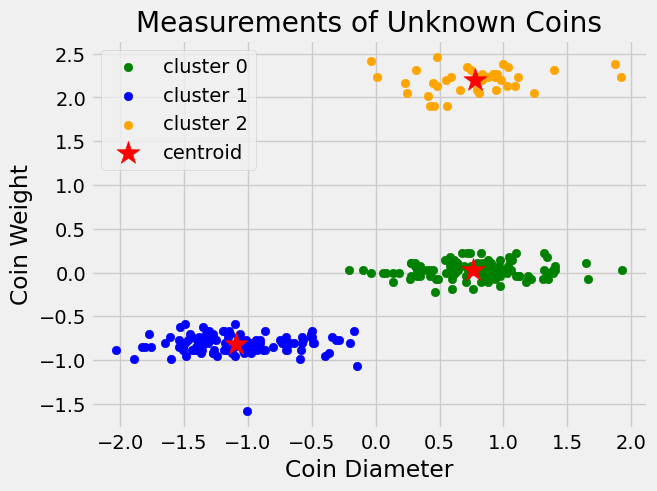

In [17]:
plt.scatter(coins_su[clust == 0].diameter, coins_su[clust == 0].weight,
            color='green', label='cluster 0')
plt.scatter(coins_su[clust == 1].diameter, coins_su[clust == 1].weight,
            color='blue', label='cluster 1')
plt.scatter(coins_su[clust == 2].diameter, coins_su[clust == 2].weight,
            color='orange', label='cluster 2')
plt.scatter(centr['diameter'], centr['weight'], marker='*', s=300, color="red", label='centroid')
plt.legend()
plt.xlabel('Coin Diameter')
plt.ylabel('Coin Weight')
plt.title('Measurements of Unknown Coins');


```{note}
Your chosen tolerance should match your use-case. For example, if I had much smaller numbers (say on the order of $10^{-4}$) the tolerance we used here would not work. We would need to use a smaller number.
```

Now that we understand the k-means algorithm, in the following section, we will work through an example where the data is higher-dimensional and, therefore, it is harder to visualize clusters graphically.